In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import copy
import matplotlib.pyplot as plt
from ncnn import NashCascadeNeuralNetwork as ncnn
from ncnn import train_model as train_ncnn
from ncn import NashCascadeNetwork as ncn
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
PRECIP_SVN_SEQ = "atmosphere_water__liquid_equivalent_precipitation_rate_seq"
DO_PLOT = True
N_TIMESTEPS = 300

In [3]:
network_precip_input_list = []
count = 0
for i in range(N_TIMESTEPS):

    ###########################################################################
    if count == 0:
        network_precip_input_list.append(3.0)
    elif count > 39:
        network_precip_input_list.append(3.0)
    else:
        network_precip_input_list.append(0.0)
    if count == 50:
        count = 0
    count+=1
    ###########################################################################
network_precip_tensor = torch.tensor(network_precip_input_list, requires_grad=False)
total_mass_precip_in = torch.sum(network_precip_tensor)

Initial Mass in network at start: 85.0
Initial Mass in network: 85.0
Final Mass in network: 21.3
Total Mass out of network 261.7
Total precipitation into network 198.0
Mass balance for network is -0.000
Mass balance for network is -0.000


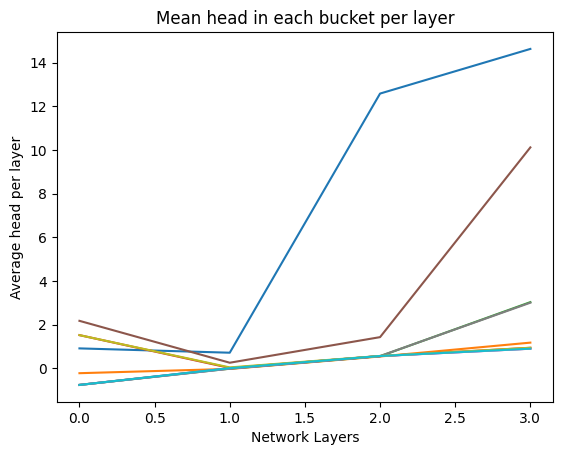

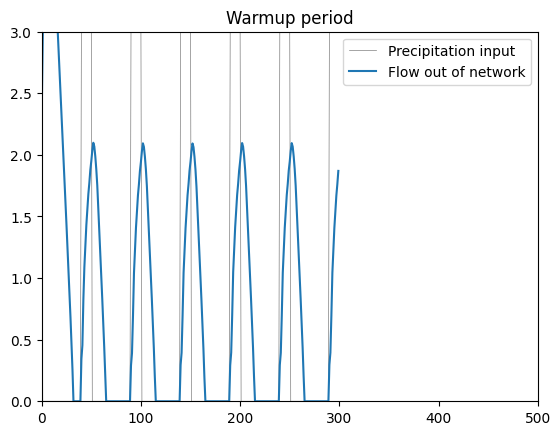

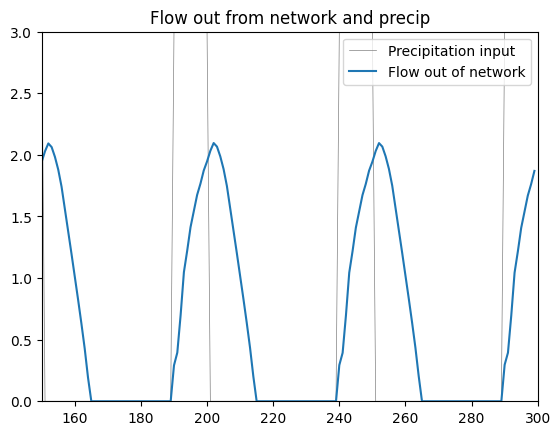

In [4]:
# Example 0
bucket_net = ncn(cfg_file="./config_0.json")
bucket_net.initialize()
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.tensor([tensor.item() for tensor in bucket_net.sum_H_per_layer]))
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_0 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    bucket_net.forward()
    network_outflow_list_0.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_net.mean_H_per_layer])

network_outflow_tensor_0 = torch.tensor(network_outflow_list_0, requires_grad=True)
bucket_net.report_out_mass_balance()
bucket_net.detach_ncn_from_graph()
bucket_net.theta.detach()

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 500

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_0)-(len(network_outflow_list_0)/2))
    endplt = int(len(network_outflow_list_0))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

Initial Mass in network at start: 40.0
Initial Mass in network: 40.0
Final Mass in network: 4.5
Total Mass out of network 233.5
Total precipitation into network 198.0
Mass balance for network is 0.000
Mass balance for network is 0.000


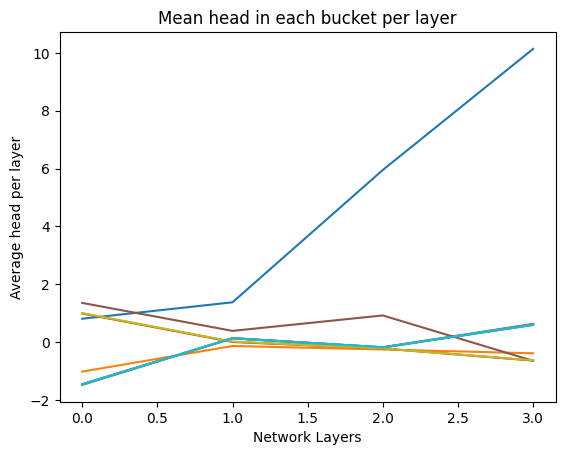

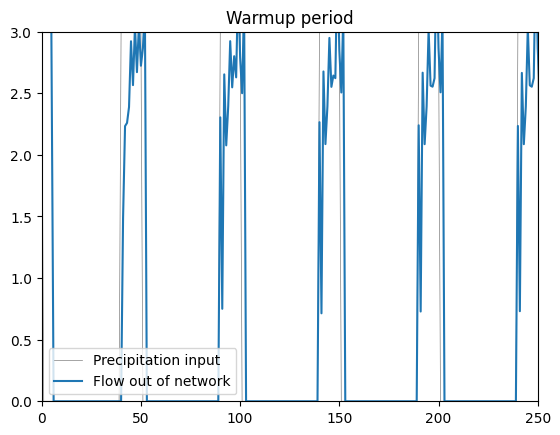

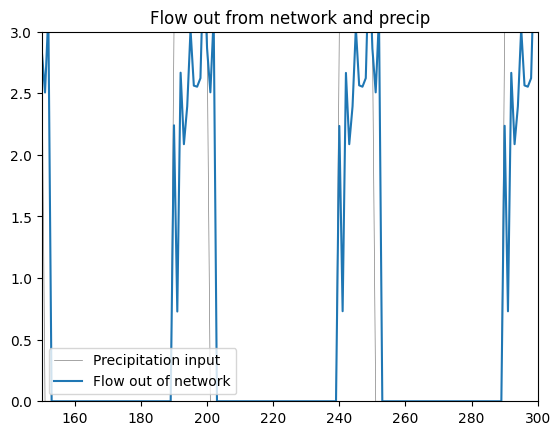

In [5]:
# Example 1
bucket_nn = ncnn(cfg_file="./config_1.json")
bucket_nn.ncn.initialize_theta_values()
inital_mass_in_network = torch.sum(torch.stack(bucket_nn.ncn.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_nn.ncn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    if bucket_nn.ncn.do_predict_theta_with_lstm:
        sequence_tensors = []
        tensor_device = bucket_nn.ncn.network[0]['H'].device
        tensor_dtype = torch.float32
        if i >= bucket_nn.ncn.input_u_sequence_length:
            sequence_tensors = [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                for item in network_precip_input_list[i-bucket_nn.ncn.input_u_sequence_length:i]]
        else:
            desired_tensor_shape = (1,)
            padding_size = bucket_nn.ncn.input_u_sequence_length - i
            padding_tensors = [torch.zeros(desired_tensor_shape, device=tensor_device, dtype=tensor_dtype) 
                            for _ in range(padding_size)]
            sequence_tensors = padding_tensors + [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                                for item in network_precip_input_list[:i]]
        sequence = torch.stack(sequence_tensors).view(1, -1)
        bucket_nn.ncn.set_value(PRECIP_SVN_SEQ, sequence)


    bucket_nn.ncn.forward()
    network_outflow_list_1.append(bucket_nn.ncn.network_outflow.item())
    bucket_nn.ncn.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_nn.ncn.mean_H_per_layer])

###########################################################################
network_outflow_tensor_1 = torch.tensor(network_outflow_list_1, requires_grad=True)
bucket_nn.ncn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.ncn.theta.detach())

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [6]:
DO_PLOT = True

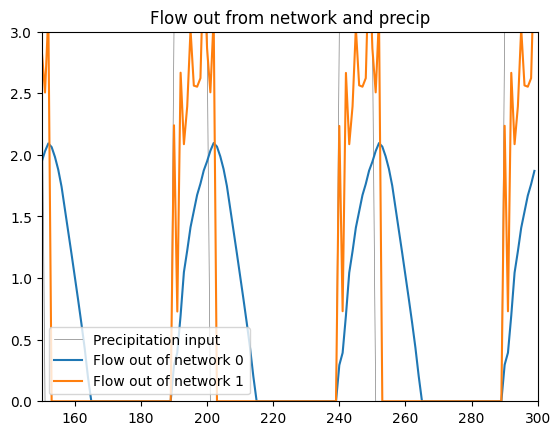

In [7]:
if DO_PLOT:
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [8]:
y_pred, loss = train_ncnn(bucket_nn, network_precip_tensor, network_outflow_tensor_0)
network_outflow_list_1 = list(y_pred.detach().numpy())
print(bucket_net.theta)
print(bucket_net.theta.grad)
print(bucket_nn.ncn.theta)
print(bucket_nn.ncn.theta.grad)

loss: 0.8719
loss: 0.7091
loss: 0.6674
loss: 0.6423
loss: 0.6364
loss: 0.6342
loss: 0.5873
loss: 0.0280
loss: 0.0119
loss: 0.0099
loss: 0.0145
loss: 0.0092
loss: 0.0093
loss: 0.0081
loss: 0.0075
loss: 0.0075
loss: 0.0074
loss: 0.0074
loss: 0.0073
loss: 0.0073
loss: 0.0073
loss: 0.0072
loss: 0.0072
loss: 0.0072
loss: 0.0072
loss: 0.0071
loss: 0.0071
loss: 0.0071
loss: 0.0071
loss: 0.0070
loss: 0.0070
loss: 0.0070
loss: 0.0070
loss: 0.0070
loss: 0.0069
loss: 0.0069
loss: 0.0069
loss: 0.0069
loss: 0.0068
loss: 0.0068
loss: 0.0068
loss: 0.0068
loss: 0.0068
loss: 0.0067
loss: 0.0067
loss: 0.0067
loss: 0.0067
loss: 0.0067
loss: 0.0067
loss: 0.0066
loss: 0.0066
loss: 0.0066
loss: 0.0066
loss: 0.0066
loss: 0.0065
loss: 0.0065
loss: 0.0065
loss: 0.0065
loss: 0.0065
loss: 0.0065
loss: 0.0064
loss: 0.0064
loss: 0.0064
loss: 0.0064
loss: 0.0064
loss: 0.0064
loss: 0.0064
loss: 0.0063
loss: 0.0063
loss: 0.0063
loss: 0.0063
loss: 0.0063
loss: 0.0063
loss: 0.0063
loss: 0.0062
loss: 0.0062
loss: 0.0062

/tmp/ipykernel_6621/4120477293.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(bucket_nn.ncn.theta.grad)


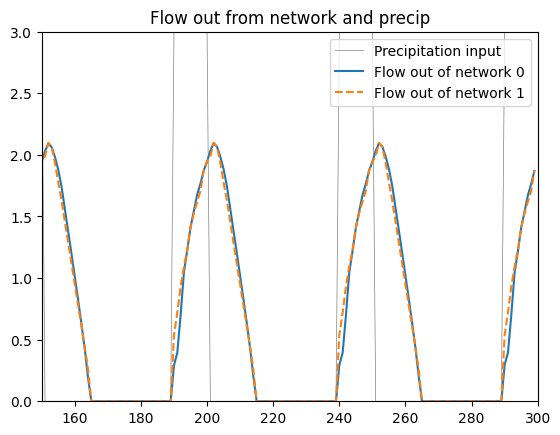

In [9]:
if DO_PLOT:
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, "--", label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [10]:
bucket_net.network

{0: {'H': tensor([2.1805]),
  'S': tensor([[[0.4970, 0.4946],
           [0.1889, 0.2311],
           [0.2222, 0.3755],
           [0.5002, 0.6115],
           [0.9526, 0.3239],
           [0.3274, 0.5747],
           [0.6601, 0.0911],
           [0.9629, 0.2758],
           [0.7546, 0.9498],
           [0.2961, 0.0215]]]),
  's_q': tensor([[1.1792, 0.3005, 0.4415, 0.5566, 0.0000, 0.4883, 0.0192, 0.0000, 0.0000,
           0.0147]])},
 1: {'H': tensor([ 0.7716,  0.2380,  0.3377,  0.2767,  0.2803,  0.0476,  0.3700,  0.0299,
           0.0376, -0.0420]),
  'S': tensor([[[0.2726, 0.5834],
           [0.7765, 0.4724],
           [0.7905, 0.6991],
           [0.0883, 0.6326],
           [0.2486, 0.5407]],
  
          [[0.9892, 0.7090],
           [0.1985, 0.7306],
           [0.4589, 0.5309],
           [0.0743, 0.3449],
           [0.6912, 0.1481]],
  
          [[0.1988, 0.1301],
           [0.9772, 0.8616],
           [0.1198, 0.7570],
           [0.1219, 0.3707],
           [0.8124, 0.

In [11]:
bucket_nn.ncn.network

{0: {'H': tensor([1.4588]),
  'S': tensor([[[0.7576, 0.2793],
           [0.4031, 0.7347],
           [0.0293, 0.7999]]]),
  's_q': tensor([[1.1447, 0.9177, 0.7959]])},
 1: {'H': tensor([-0.3468,  0.7544,  0.4835]),
  'S': tensor([[[0.3971, 0.7544],
           [0.5695, 0.4388],
           [0.6387, 0.5247]],
  
          [[0.6826, 0.3051],
           [0.4635, 0.4550],
           [0.5725, 0.4980]],
  
          [[0.9371, 0.6556],
           [0.3138, 0.1980],
           [0.4162, 0.2843]]]),
  's_q': tensor([[1.1149, 0.0000, 0.0000],
          [0.7759, 0.5009, 0.0000],
          [0.7858, 0.0000, 0.0000]])},
 2: {'H': tensor([ 3.4388,  0.0394, -0.8320]),
  'S': tensor([[[0.3398, 0.5239]],
  
          [[0.7981, 0.7718]],
  
          [[0.0112, 0.8100]]]),
  's_q': tensor([[2.6279],
          [1.1652],
          [0.0000]])},
 3: {'H': tensor([11.3949]),
  'S': tensor([[[0.6397, 0.9743]]]),
  's_q': tensor([[1.8740]])}}

In [12]:
bucket_net.theta

tensor([0.2488, 0.2480, 0.2406, 0.2423, 0.2431, 0.2449, 0.2461, 0.2478, 0.2440,
        0.2468, 0.2451, 0.2456, 0.2498, 0.2452, 0.2418, 0.2447, 0.2434, 0.2489,
        0.2498, 0.2429, 0.2413, 0.2457, 0.2466, 0.2424, 0.2457, 0.2473, 0.2448,
        0.2493, 0.2485, 0.2444, 0.2427, 0.2464, 0.2481, 0.2456, 0.2496, 0.2447,
        0.2493, 0.2441, 0.2452, 0.2412, 0.2436, 0.2479, 0.2465, 0.2494, 0.2478,
        0.2479, 0.2420, 0.2422, 0.2461, 0.2458, 0.2404, 0.2455, 0.2472, 0.2485,
        0.2402, 0.2485, 0.2429, 0.2498, 0.2486, 0.2415, 0.2428, 0.2482, 0.2467,
        0.2408, 0.2422, 0.2454], requires_grad=True)

In [13]:
bucket_nn.ncn.theta

tensor([0.4907, 0.4827, 0.4437, 0.5481, 0.5009, 0.5600, 0.4946, 0.4858, 0.4384,
        0.4697, 0.5659, 0.4361, 0.4734, 0.5349, 0.5340, 0.1223],
       grad_fn=<SelectBackward0>)

In [14]:
origional_bucket_theta

tensor([0.4955, 0.4747, 0.4423, 0.5526, 0.5074, 0.5694, 0.4982, 0.4878, 0.4437,
        0.4773, 0.5525, 0.4419, 0.4751, 0.5397, 0.5311, 0.5282])

In [15]:
torch.sum(bucket_nn.ncn.theta - origional_bucket_theta)

tensor(-0.4361, grad_fn=<SumBackward0>)

In [16]:
bucket_nn.ncn.theta - origional_bucket_theta

tensor([-0.0048,  0.0081,  0.0014, -0.0046, -0.0065, -0.0093, -0.0036, -0.0019,
        -0.0054, -0.0075,  0.0134, -0.0058, -0.0017, -0.0049,  0.0029, -0.4059],
       grad_fn=<SubBackward0>)